In [92]:
import os
import math
import pandas as pd
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
from collections import OrderedDict

#### <font color = purple> Import Calibration Trace Data</font><br>

In [93]:
os.chdir("C:/Users/q0hecjrk/Documents/_Data/Iolanda/")
calibration_df = pd.read_csv("Inputs/Calibration/trace.csv")
calibration_df.set_index('timestep', inplace=True)
calibration_df.head()

,year,month,kaoma_precip,min_temp,max_temp
timestep,,,,,
1,1,1,242.5,18,29
2,1,2,209.1,18,29
3,1,3,97.6,17,29
4,1,4,5.6,14,29
5,1,5,0.0,10,28


# <font color = purple> Zhang water balance model </font><br>
This model accepts as inputs monthly precipitaiton and temperatures data extends a Buydko waterbalance to monthly timestep analysis and produces streaflow volume outputs. It is published in: <font color = purple> Journal of Hydrology 360(1-4):117-131 October 2008 (DOI: 10.1016/j.jhydrol.2008.07.021) </font>
 1. <font color = blue> Potential evaportranspiration (PET) model
 2. <font color = blue> Soil moisture accounting 
 3. <font color = blue> Groundwater accounting
 4. <font color = blue> Evaportranspiration (ET) model
 5. <font color = blue> Streamflow model  

## <font color=purple> 1.  Hargreaves PET

In [94]:
def hargreaves_pet(month, precip, tmin, tmax):
    days_in_month = { 1:31, 2:28.25, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    solar_radiation = { 1:40.8, 2:40.4, 3:38.8, 4:35.4, 5:31, 6:27.7, 7:26.9, 8:29, 9:33, 10:37, 11:39.5, 12:40.5} #in Ra
    daily_pet = 0.0013 * 0.408 * solar_radiation[month] * ((tmin + tmax) / 2 + 17) * ((tmax - tmin) - 0.0123 * precip)**0.76
    return daily_pet * days_in_month[month]

#### <font color=blue> Compute PET for calibration period </font>

In [95]:
for index, row in calibration_df.iterrows():
    calibration_df.at[index,'pet'] = hargreaves_pet(row['month'], row['kaoma_precip'], row['min_temp'], row['max_temp'])

#### <font color=blue> Import PET test data and compute error </font>

In [96]:
pet_df = pd.read_csv("Inputs/Calibration/pet.csv")
pet_df.set_index('timestep', inplace=True)
pet_df = pet_df.rename(columns = {'pet':'test_pet'})
pet_error_df = calibration_df.merge(pet_df.drop(['year', 'month'], axis=1), how='left', on='timestep')
for index, row in pet_error_df.iterrows():    
    calibration_df.at[index,'pet_error'] = row['test_pet'] - row['pet']
calibration_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,pet_error
timestep,,,,,,,
1,1,1,242.5,18,29,132.172078,-0.044283
2,1,2,209.1,18,29,123.883007,0.089950
3,1,3,97.6,17,29,155.684118,-0.026484
4,1,4,5.6,14,29,169.238425,-0.111617
5,1,5,0.0,10,28,165.057973,0.198921


#### <font color=blue> Graph error between computed result for calibration period and test data </font><br>
This almost certainly shows a minor difference in the level of precision between the Python and Excel solar radiation data (constants)

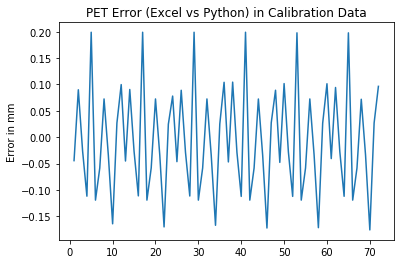

In [97]:
pet_error_figure = plt.figure()
pet_error_figure = plt.title('PET Error (Excel vs Python) in Calibration Data')
pet_error_figure = plt.ylabel("Error in mm")
pet_error_figure = plt.plot(calibration_df.index, calibration_df['pet_error'])
pet_error_figure = plt.show()

## <font color = purple>2. Soil moisture account </font>
 - <font color = blue> equation 11. Xt: rainfall available for storage and evaportranspiration (rainfall that will not runoff)
 - equation 13. Wt: water avialability (Xt + water being stored already:St-1)
 - equation 14. Et: evaportranspiration
 - equation 15 and 16: Yt: evaportranspiration opportunity (potential evaportranspiration + soilwater storage capacity)

In [98]:
#Zhang constants these could be iteratively set to maximize a nash-sutcliffe score
soil_max = 100
soil_initial = 22.77650
alpha_one = 11.142492
alpha_two = 1.582649

In [99]:
def zhang_soilstorage(precip, pet, soil_max, soil_previous, alpha_one, alpha_two):
    # Xt equation 11: rainfall available for storage and evaportranspiration (rainfall that will not runoff)
    # Wt equation 13: water avialability (Xt + water being stored already:St-1)
    # Et equation 14: evaportranspiration
    # Yt equation 15 and 16: evaportranspiration opportunity (potential evaportranspiration + soilwater storage capacity)
  
    # compute Wt
    if precip == 0:
        #equation 11: Xt = [1 + ((Smax - Stminusone + HargreavesPET)/Precipitation) - [1 - ((Smax -Stminusone + HargreavesPET)/Precipitation)^AlphaOne]^(1/AlphaOne)] * Precipitation
        #equation 13: Wt = Xt + St-1
        Xt = 0
        Wt = soil_previous
    else:
        Xt = (1 + ((soil_max - soil_previous + pet) / precip) - (1 ((soil_max - soil_previous + pet) / precip)**alpha_one)**(1 / alpha_one)) * precip
        Wt = Xt + soil_previous
    
    # return soilstorage
    if Wt < 0.1:
        soil_storage = 0
    else:
        Et = (1 + (pet / Wt) - (1 + (pet / Wt) ^ alpha_two) ^ (1 / alpha_two)) * Wt
        Yt = (1 + ((pet + soil_max) / Wt) - (1 + ((pet + soil_max) / Wt)**alpha_two)**(1 / alpha_two)) * Wt
        soil_storage = Yt - Et
    return soil_storage

## <font color = purple>3. Groundwater account </font>
   - <font color = blue> equation 11. Xt: </font> rainfall available for storage and evaportranspiration (rainfall that will not runoff) 
   - <font color = blue> equation 13. Wt: </font> water avialability (Xt + water being stored already:Stminusone) 
   - <font color = blue> equation 15. and 16. Yt: </font> evaportranspiration opportunity (potential evaportranspiration + soilwater storage capacity) 
   - <font color = blue> equation 17. Rt: </font> groundwater recharge

In [100]:
#additional groundwater storage constants, the ground_loss_constant is not part of the Zhang system of equations
ground_initial = 150
ground_constant = 0.08
ground_loss_constant = 0.25

In [101]:
def zhang_groundstorage(precip, pet, soil_storage, soil_max, ground_previous, ground_constant, ground_loss_constant, alpha_two):
    #Xt equation 11: rainfall available for storage and evaportranspiration (rainfall that will not runoff)
    #Wt equation 13: water avialability (Xt + water being stored already:Stminusone)
    #Yt equation 15 and 16: evaportranspiration opportunity (potential evaportranspiration + soilwater storage capacity)
    #Rt equation 17: groundwater recharge
    
    # compute Wt
    if precip == 0:
        #equation 11: Xt = [1 + ((Smax - Stminusone + HargreavesPET)/Precipitation) - [1 - ((Smax -Stminusone + HargreavesPET)/Precipitation)^AlphaOne]^(1/AlphaOne)] * Precipitation
        #equation 13: Wt = Xt + St-1
        Xt = 0
        Wt = soil_storage
    else:
        Xt = (1 + ((soil_max - soil_storage + pet) / precip) - (1 + ((soil_max - soil_storage + pet) / precip)**alpha_one)**(1 / alpha_one)) * precip
        Wt = Xt + soil_storage
    
    # return groundwater storage (Gt)
    if Wt < 0.1:
        Rt = 0
    else:
        Yt = (1 + ((pet + soil_max) / Wt) - (1 + ((pet + soil_max) / Wt)**alpha_two)**(1 / alpha_two)) * Wt
        Rt = Wt - Yt
    return ground_previous + Rt - ground_previous * ground_constant - ground_previous * gound_loss_constant

## <font color = purple>4. Evaportranspiration account </font>

In [102]:
def zhang_evaportransporation(precip, pet, soil_storage, soil_max, alpha_one, alpha_two):
    # compute Wt
    if precip == 0:
        Xt = 0
        Wt = soil_storage
    else:
        Xt = (1 + ((soil_max - soil_storage + pet) / precip) - (1 + ((soil_max - soil_storage + pet) / precip)**alpha_one)**(1 / alpha_one)) * precip
        Wt = Xt + soil_storage
    
    # compute evaportranspiration (Et)
    if Wt < 0.1:
        return 0
    else:
        return (1 + (pet / Wt) - (1 + (pet / Wt)**alpha_two)**(1 / alpha_two)) * Wt

## <font color = purple>5. Stream flow volume model </font>
   - <font color = blue>baseflow</font>
   - <font color = blue>runoff</font>

In [103]:
# Baseflow in Millions of Cubic Meters (MCM)
def zhang_baseflow(ground_previous, ground_constant, watershed_size):
    return ground_constant * ground_previous * watershed_size / 1000

In [104]:
def zhang_runoff(precip, pet, soil_previous, soil_max, alpha_one):
    # compute direct runoff + Wt
    if precip == 0:
        return 0
    else:
        #equation 11: Xt
        Xt = (1 + ((soil_max - soil_previous + pet) / precip) - (1 - ((soil_max - soil_previous + pet) / precip)**alpha_one)**(1 / alpha_one)) * precip
        return (precip - Xt) * watershed_size / 1000

In [105]:
def zhang_streamflowvolume(runoff, baseflow):
    return runoff + baseflow

In [106]:
os.chdir("C:/Users/q0hecjrk/Documents/_Data/Iolanda/")
trace_1_100 = pd.read_csv("Outputs/traces/trace_t0_p100.csv")
trace_1_100.set_index('timestep', inplace=True, drop=True, verify_integrity=True)
trace_1_100.head()

,month,year,kaoma_precip,min_temp,max_temp
timestep,,,,,
0,1,1.0,279.1,17.8,26.3
1,2,1.0,72.1,17.2,26.8
2,3,1.0,91.8,16.8,27.1
3,4,1.0,14.2,15.7,26.0
4,5,1.0,0.0,11.1,25.6


In [15]:
pet = hargreaves_pet(1, 279.1, 17.8, 26.3)
print(pet)

(-226.02727662454643+212.25374077015016j)


In [16]:
i = 0
trace_df = trace_1_100.copy(deep=True)
for index, row in trace_df.iterrows():
    pet = hargreaves_pet(row['month'], row['kaoma_precip'], row['min_temp'], row['max_temp'])
    print(pet)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


nan
18.61920190948973
nan
108.94803220538964
137.5168776039422
120.0355243538532
121.2719296067849
147.9999786793912
175.52905673004946
20.06240669376329
143.46311153565193
nan
nan
nan
nan
137.02449692211695
137.5168776039422
118.5777873541345
124.56654212998241
116.93228976916453
138.43892505704105
133.1276238057632
nan
130.1545284809061
86.70814533213121
81.33165710962753
66.92399436003633
124.21835844417556
120.46983258780007
107.62520623464206
116.36327242813154
137.65801740506194
163.38483750994814
141.8832161003677
77.79020836575512
nan
nan
nan
84.12482060900011
114.7106577688398
133.11924310664685
104.7380226803722
106.0775397380795
116.93228976916453
176.32397328198306
151.82630815991132
nan
nan
nan
nan
49.0143384669755
97.76882569846117
144.7585623406215
104.7380226803722
121.2719296067849
147.9999786793912
172.53791070550517
nan
134.76326262632733
nan
nan
90.43771119979925
49.0143384669755
127.84589936100316
120.46983258780007
107.62520623464206
103.59223586092203
112.3982103

nan
nan
nan
144.7585623406215
107.62520623464206
116.36327242813154
116.93228976916453
149.40335958955683
188.3593467516846
80.58619907183147
nan
nan
nan
nan
118.57986672427428
144.7585623406215
124.3068302668502
124.56654212998241
133.49573064824727
165.73442753013651
124.71755099696999
nan
73.09767174075664
nan
nan
91.32391761086178
141.13573375085264
144.7585623406215
120.0355243538532
121.0698913608926
116.93228976916453
140.56588867841822
nan
nan
nan
nan
nan
38.17862688420062
115.18954659463498
120.46983258780007
120.0355243538532
121.2719296067849
133.49573064824727
163.38483750994814
133.6034294921461
nan
nan
nan
nan
91.32391761086178
125.47297829166358
133.11924310664685
124.3068302668502
103.59223586092203
144.5873179174138
163.8361698861175
135.2411835589764
15.278984560874028
nan
nan
nan
170.15207943990268
100.02865749998139
120.46983258780007
118.5777873541345
124.56654212998241
116.93228976916453
175.52905673004946
20.06240669376329
104.16521798487499
nan
nan
nan
nan
135.9

120.0355243538532
124.56654212998241
115.36742577658163
174.03551304630096
81.81729773165446
nan
nan
nan
nan
nan
115.18954659463498
154.6284643183911
118.5777873541345
100.99461631676508
116.93228976916453
173.33714050370295
135.2411835589764
nan
nan
nan
42.36658902725633
nan
nan
131.54148528015125
124.3068302668502
121.0698913608926
133.49573064824727
165.73442753013651
9.648594443949744
80.58619907183147
nan
93.76406139185485
nan
120.40848888305347
97.76882569846117
132.7936391116861
124.3068302668502
124.56654212998241
144.5873179174138
147.62133706381968
nan
nan
nan
nan
nan
103.05830625604239
139.79556994134663
132.7936391116861
120.0355243538532
124.56654212998241
147.9999786793912
165.9777303917124
nan
77.79020836575512
nan
nan
74.55927897133768
65.2182749549728
134.988251333367
131.90766630409897
118.5777873541345
124.56654212998241
137.65801740506194
175.827283398038
132.3103516708357
nan
nan
nan
nan
nan
139.3703870810089
144.7585623406215
107.62520623464206
106.0775397380795
1

nan
nan
nan
115.18954659463498
144.7585623406215
120.0355243538532
124.56654212998241
144.5873179174138
165.9777303917124
141.8832161003677
nan
nan
nan
nan
84.12482060900011
118.57986672427428
120.46983258780007
120.0355243538532
121.0698913608926
147.9999786793912
165.48650073723957
132.3103516708357
15.278984560874028
nan
nan
nan
nan
112.50193694704723
131.90766630409897
120.0355243538532
121.0698913608926
147.9999786793912
109.65764666768455
133.6034294921461
nan
nan
nan
104.61556841302985
91.32391761086178
125.47297829166358
154.6284643183911
124.3068302668502
103.59223586092203
147.9999786793912
159.9527076445487
187.32884801757874
nan
nan
nan
nan
49.0143384669755
107.58647947079061
120.11497389084717
107.62520623464206
124.56654212998241
146.44288716284467
140.56588867841822
105.31466367637584
nan
nan
nan
nan
nan
121.664575705896
137.5168776039422
107.62520623464206
121.2719296067849
137.65801740506194
165.9777303917124
25.21848237340223
15.278984560874028
nan
nan
99.191845773493

149.5079749226201
nan
52.48719695233626
nan
nan
nan
nan
132.93230836848682
120.46983258780007
104.7380226803722
121.2719296067849
137.65801740506194
149.1940594832454
32.65448222991014
nan
nan
nan
nan
151.66655828939523
134.5583341623026
137.5168776039422
107.62520623464206
124.56654212998241
137.65801740506194
149.40335958955683
141.8832161003677
nan
nan
nan
74.27121367977168
63.65767121991731
135.18510211723898
137.5168776039422
104.7380226803722
121.2719296067849
133.49573064824727
164.43246959985788
46.877937138757474
nan
nan
nan
18.61920190948973
nan
115.18954659463498
133.11924310664685
104.7380226803722
106.0775397380795
116.93228976916453
141.59576074964522
164.66520407475906
nan
nan
68.2366119638462
nan
136.2166618605132
109.01055223321862
133.11924310664685
124.3068302668502
103.59223586092203
144.5873179174138
150.23963660427293
nan
80.58619907183147
nan
nan
nan
nan
107.58647947079061
154.6284643183911
124.3068302668502
124.56654212998241
133.49573064824727
165.2245463103198

nan
nan
104.61556841302985
72.45911718046834
134.988251333367
132.7936391116861
124.3068302668502
116.36327242813154
125.79963499138742
149.1940594832454
91.53747320848909
15.278984560874028
nan
nan
nan
16.254597594163865
108.94803220538964
120.46983258780007
120.0355243538532
103.59223586092203
133.49573064824727
147.62133706381968
134.45720039240402
nan
nan
nan
nan
nan
108.42594074166163
120.46983258780007
120.0355243538532
103.59223586092203
133.49573064824727
161.643835909517
70.5641792553815
nan
nan
nan
nan
91.32391761086178
127.39442106156558
153.32952424957315
120.0355243538532
121.2719296067849
147.9999786793912
137.32067908480153
164.66520407475906
nan
nan
nan
nan
50.36829859666177
119.2747806843312
154.6284643183911
124.3068302668502
106.0775397380795
147.9999786793912
149.40335958955683
187.32884801757874
nan
nan
nan
nan
121.67671280994763
nan
133.11924310664685
120.0355243538532
103.59223586092203
133.49573064824727
147.62133706381968
130.9325006718591
15.278984560874028
73

nan
nan
58.03228921654409
nan
97.76882569846117
144.7585623406215
104.7380226803722
116.36327242813154
134.350447894563
176.32397328198306
188.3593467516846
nan
nan
nan
nan
63.32554982874475
118.57986672427428
120.46983258780007
118.5777873541345
121.0698913608926
131.89278825824172
165.73442753013651
167.6735578145672
nan
nan
nan
nan
162.95726280127312
123.19290110060605
132.7936391116861
118.5777873541345
121.2719296067849
137.65801740506194
170.23357199981524
133.1276238057632
nan
nan
nan
104.61556841302985
91.32391761086178
139.79556994134663
120.46983258780007
104.7380226803722
116.36327242813154
144.5873179174138
164.43246959985788
115.17761665327002
nan
nan
nan
nan
128.3866183486199
108.94803220538964
132.7936391116861
107.62520623464206
116.36327242813154
135.40020073337433
105.8873525123352
119.92193953185495
nan
nan
nan
nan
144.5095330404259
120.54654583646297
154.6284643183911
124.3068302668502
103.59223586092203
137.65801740506194
147.62133706381968
117.4891207280063
nan
na

nan
nan
nan
nan
153.06014184755546
135.5059595700763
144.60999690334918
120.0355243538532
116.36327242813154
137.65801740506194
165.9777303917124
nan
nan
nan
nan
nan
nan
129.15054493793673
144.7585623406215
118.5777873541345
106.0775397380795
133.49573064824727
149.1940594832454
117.4891207280063
nan
nan
nan
nan
nan
134.5583341623026
120.46983258780007
124.3068302668502
106.0775397380795
144.5873179174138
140.8689090574393
120.55497554274542
nan
nan
nan
nan
72.45911718046834
138.30563162884297
127.65110689314923
104.7380226803722
106.0775397380795
147.9999786793912
164.91837899809616
nan
137.90521859480344
nan
nan
60.04417696955798
121.67671280994763
97.76882569846117
120.46983258780007
107.62520623464206
103.59223586092203
144.5873179174138
147.62133706381968
46.877937138757474
nan
nan
nan
nan
91.32391761086178
125.47297829166358
144.7585623406215
104.7380226803722
121.0698913608926
137.65801740506194
176.32397328198306
134.81228375356545
nan
nan
nan
nan
65.2182749549728
109.010552233

118.5777873541345
116.36327242813154
127.61478846833238
165.1915418527262
190.4150280653991
nan
nan
nan
nan
65.2182749549728
107.58647947079061
120.46983258780007
120.0355243538532
103.59223586092203
147.9999786793912
164.6310843958524
188.3593467516846
nan
nan
nan
nan
109.95334361822508
135.39903376926196
144.7585623406215
104.7380226803722
116.36327242813154
133.49573064824727
144.14252690796118
nan
nan
nan
nan
44.17881780171382
nan
108.94803220538964
144.7585623406215
118.5777873541345
103.59223586092203
116.93228976916453
165.9777303917124
141.8832161003677
nan
nan
nan
nan
nan
141.13573375085264
123.50184598367629
118.5777873541345
103.59223586092203
147.6889757100032
158.53858234888966
151.82630815991132
nan
nan
nan
nan
162.3003294308458
109.01055223321862
144.7585623406215
124.3068302668502
116.36327242813154
103.16160302659299
165.1915418527262
177.97165530967783
nan
nan
nan
nan
43.95760800193864
117.08905167108978
133.11924310664685
120.0355243538532
121.2719296067849
116.93228

nan
72.45911718046834
121.80644022660594
144.7585623406215
120.0355243538532
103.59223586092203
144.5873179174138
107.605597150539
190.4150280653991
nan
nan
nan
nan
nan
138.3829977589173
120.46983258780007
120.0355243538532
124.56654212998241
137.65801740506194
140.8689090574393
25.21848237340223
nan
nan
nan
nan
151.66655828939523
126.42777117034596
144.7585623406215
124.3068302668502
124.56654212998241
133.49573064824727
164.43246959985788
44.55369721124243
nan
nan
nan
nan
nan
138.3829977589173
144.7585623406215
104.7380226803722
103.59223586092203
137.65801740506194
165.73442753013651
nan
25.86907018178463
nan
nan
82.51029423846771
nan
115.18954659463498
120.46983258780007
104.7380226803722
103.59223586092203
137.65801740506194
149.1940594832454
167.78934455970744
15.278984560874028
nan
nan
90.43771119979925
139.19691734219825
nan
154.6284643183911
120.0355243538532
116.36327242813154
112.39821032355356
164.6310843958524
133.1276238057632
15.278984560874028
nan
nan
nan
96.75225992839

In [36]:
def zhang_hydrology(input_df):
    for i in range(0, len(input_df), 1):
        

SyntaxError: unexpected EOF while parsing (<ipython-input-36-3cca2ee78f21>, line 3)